Strategy rules:

1. Check if today's close is in the bottom n % of the day's range
2. If condition is met then enter on the close and exit the next day's close, unless the signal is repeated.

In [1]:
#import libraries
import yfinance as yf
import numpy as np
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

In [2]:
#define starting variables
SYMBOL = "^GSPC"
STARTING_BALANCE = 10000
PCT_THRESH = 20

In [3]:
#define date range
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2020, 1, 1)
YEARS = (END - START).days/ 365.25

In [4]:
#download data
price = yf.download(SYMBOL, start=START, end=END)

price.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


In [5]:
#drop redundant columns
price = price.drop(['Volume', 'Adj Close'], axis=1)

price.tail()

,Open,High,Low,Close
Date,,,,
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020
2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039
2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029


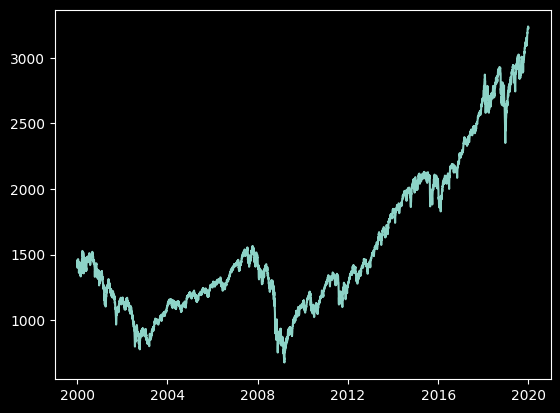

In [6]:
#plot chart
plt.style.use('dark_background')
plt.plot(price.Close)
plt.show()

In [7]:
#calculate benchmark return and balance
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1
price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()

price.tail()

,Open,High,Low,Close,Return,Bench_Bal
Date,,,,,,
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,0.999805,22150.464862
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,1.005128,22264.056138
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,1.000034,22264.812776
2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,0.994219,22136.103846
2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,1.002946,22201.317288


In [8]:
#calculate benchmark drawdown
price['Bench_Peak'] = price.Bench_Bal.cummax()
price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

bench_dd = round(((price.Bench_DD / price.Bench_Peak).min() * 100), 2)

bench_dd

-56.78

In [9]:
#calculate additional columns for strategy

#daily range
price['Range'] = price.High - price.Low
#distance between close and daily low
price['Dist'] = abs(price.Close - price.Low)
#distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct
Date,,,,,,,,,,,
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,0.999805,22150.464862,22154.794977,-4.330115,5.919922,2.869873,48.478225
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,1.005128,22264.056138,22264.056138,0.000000,12.880127,12.709961,98.678848
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,1.000034,22264.812776,22264.812776,0.000000,13.559814,5.649902,41.666517
2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,0.994219,22136.103846,22264.812776,-128.708930,24.349854,4.719971,19.383980
2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,1.002946,22201.317288,22264.812776,-63.495488,19.689941,18.750000,95.226286


In [10]:
#identify entries and allocate trading fees
price['Long'] = np.logical_and((price.Pct < PCT_THRESH), (price.Range > 10))

In [11]:
#calculate system return and balance
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())

price.tail()

,Open,High,Low,Close,Return,Bench_Bal,Bench_Peak,Bench_DD,Range,Dist,Pct,Long,Sys_Ret,Sys_Bal
Date,,,,,,,,,,,,,,
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,0.999805,22150.464862,22154.794977,-4.330115,5.919922,2.869873,48.478225,False,1.000000,37470.830967
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,1.005128,22264.056138,22264.056138,0.000000,12.880127,12.709961,98.678848,False,1.000000,37470.830967
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,1.000034,22264.812776,22264.812776,0.000000,13.559814,5.649902,41.666517,False,1.000000,37470.830967
2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,0.994219,22136.103846,22264.812776,-128.708930,24.349854,4.719971,19.383980,True,1.000000,37470.830967
2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,1.002946,22201.317288,22264.812776,-63.495488,19.689941,18.750000,95.226286,False,1.002946,37581.220847


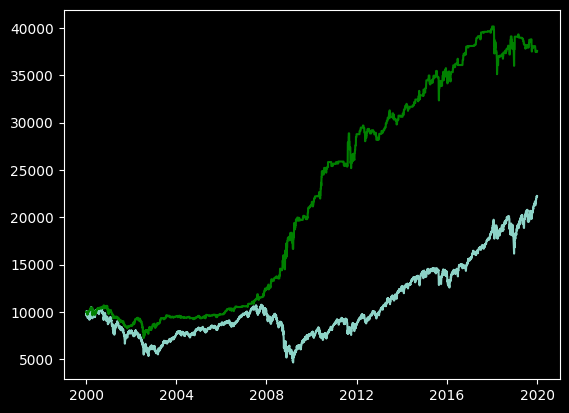

In [12]:
#plot balance
plt.plot(price.Bench_Bal)
plt.plot(price.Sys_Bal, color="g")

plt.show()

In [13]:
#calculate system drawdown
price['Sys_Peak'] = price.Sys_Bal.cummax()
price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak

sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)

sys_dd

-32.29

In [14]:
#calculate metrics
bench_return = round(((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0]) - 1) * 100, 2)
bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_return = round(((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0]) - 1) * 100, 2)
sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
sys_in_market = round((price.Long.value_counts().loc[True] / len(price)) * 100)
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Total return: {bench_return}%')
print(f'Benchmark CAGR: {bench_cagr}')
print(f'Benchmark DD: {bench_dd}%')
print('')
print(f'System Total return: {sys_return}%')
print(f'System CAGR: {sys_cagr}')
print(f'System DD: {sys_dd}%')
print(f'Time in Market: {sys_in_market}%')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'Winrate: {sys_winrate}%')

Benchmark Total return: 122.01%
Benchmark CAGR: 4.07
Benchmark DD: -56.78%

System Total return: 275.81%
System CAGR: 6.84
System DD: -32.29%
Time in Market: 19%
Trades Won: 548
Trades Loss: 391
Winrate: 58.36%


In [15]:
#define list of ETFs to backtest
symbols = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^N225']

In [16]:
#create backtesting function
def backtest(s):
    #download data
    price = yf.download(s, start=START, end=END)
    
    #drop redundant columns
    price = price.drop(['Volume', 'Adj Close'], axis=1)
    
    #calculate benchmark return and balance
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    
    #calculate benchmark drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak
    
    #calculate additional columns for strategy
    #daily range
    price['Range'] = price.High - price.Low
    #distance between close and daily low
    price['Dist'] = abs(price.Close - price.Low)
    #distance as % of range
    price['Pct'] = (price.Dist / price.Range) * 100
    
    #identify entries and allocate trading fees
    price['Long'] = np.logical_and((price.Pct < PCT_THRESH), (price.Range > 10))
    
    #calculate system return and balance
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1)
    price['Sys_Bal'] = (STARTING_BALANCE * price.Sys_Ret.cumprod())
    
    #calculate system drawdown
    price['Sys_Peak'] = price.Sys_Bal.cummax()
    price['Sys_DD'] = price.Sys_Bal - price.Sys_Peak
    
    #calculate metrics
    bench_cagr = round(((((price.Bench_Bal.iloc[-1]/price.Bench_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    sys_cagr = round(((((price.Sys_Bal.iloc[-1]/price.Sys_Bal.iloc[0])**(1/YEARS))-1)*100), 2)
    sys_dd = round(((price.Sys_DD / price.Sys_Peak).min()) * 100, 2)
    
    return bench_cagr, sys_cagr

In [17]:
#backtest multiple symbols
bc = []
sc = []


for symbol in symbols:
    bench_cagr, sys_cagr = backtest(symbol)
    bc.append(bench_cagr)
    sc.append(sys_cagr)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


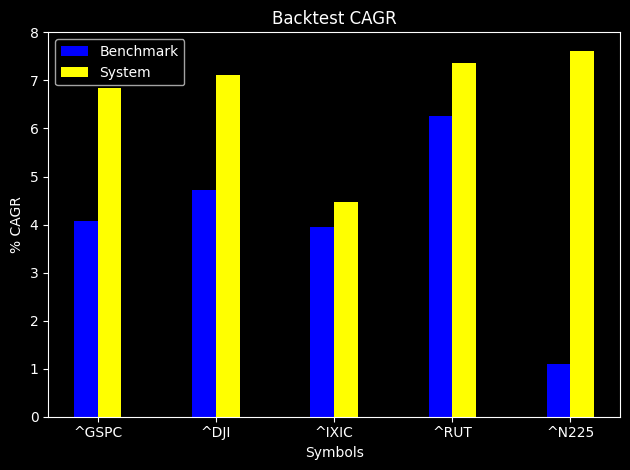

In [18]:
#plot data
x_indices = np.arange(len(symbols))
width = 0.2

plt.bar(x_indices - width / 2, bc, width = width, label = 'Benchmark', color="blue")
plt.bar(x_indices + width / 2, sc, width = width, label = 'System', color="yellow")
   
plt.xticks(ticks = x_indices, labels = symbols)

plt.legend()

plt.title('Backtest CAGR')
plt.xlabel('Symbols')
plt.ylabel('% CAGR')
plt.tight_layout()

plt.show()